In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# Create m x n matrix for Y
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

def center(train, test):
    avg = np.mean(train[:,2])
    train[:,2] = train[:,2 ] - avg
    test[:,2] = test[:, 2] - avg

center(Y_train, Y_test)

## Method 2 (Adding Bias Term a and b)
### Train Model

In [4]:
def grad_U(Ui, Yij, Vj, reg, eta, a, b):
    return eta * (np.dot(reg, Ui) - (np.dot(Vj, ((Yij) - np.dot(Ui, Vj) - a - b ))))

def grad_V(Ui, Yij, Vj, reg, eta, a, b):
    return eta * (np.dot(reg, Vj) - (np.dot(Ui, ((Yij) - np.dot(Ui, Vj) - a - b ))))

def grad_A(Ui, Yij, Vj, reg, eta, a, b):
    return -eta * ((Yij) - np.dot(Ui, Vj) - a - b  - (reg * a))
    
def grad_B(Ui, Yij, Vj, reg, eta, a, b):
    return -eta * ((Yij) - np.dot(Ui, Vj) - a - b  - (reg * b))
    
def get_err(U, V, Y, A, B, reg=0.0):
    err = 0.0
    for (i, j, Yij) in Y:
        err += .5 * (((Yij) - (np.dot(U[i-1], V[j-1]) + A[i-1] + B[j-1])) ** 2)
        
    err += 0.5 * reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2 
                    + np.linalg.norm(A)**2 + np.linalg.norm(B)**2)
    
    return err / len(Y)

In [5]:
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
  
    itr = 0
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))

    A = np.random.uniform(-0.5, 0.5, (M))
    B = np.random.uniform(-0.5, 0.5, (N))
   
    curr_loss = get_err(U, V, Y, A, B)
    
    shuffled = np.random.permutation(list(range(len(Y))))
    
    for k in range(len(Y)):
        i, j, Yij = Y[shuffled[k]]
        
        # update U, V, A, B
        u = grad_U(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        v = grad_V(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        a = grad_A(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        b = grad_B(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        
        U[i-1] = U[i-1] - u 
        V[j-1] = V[j-1] - v
        A[i-1] = A[i-1] - a
        B[j-1] = B[j-1] - b
        
    next_loss = get_err(U, V, Y, A, B)
    init = curr_loss - next_loss
    curr_delta = init
    curr_loss = next_loss
    
    while itr < max_epochs and (curr_delta / init) > eps:
        shuffled = np.random.permutation(list(range(len(Y))))
        for k in range(len(Y)): 
            i, j, Yij = Y[shuffled[k]]
            
            # update U, V, A, B
            u = grad_U(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
            v = grad_V(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
            a = grad_A(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
            b = grad_B(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])

            U[i-1] = U[i-1] - u 
            V[j-1] = V[j-1] - v
            A[i-1] = A[i-1] - a
            B[j-1] = B[j-1] - b
            
        next_loss = get_err(U,V,Y, A,B)
        
        curr_delta = curr_loss - next_loss
        curr_loss = next_loss
        itr += 1
        
    return U, V, curr_loss, A, B

In [7]:
# Create 943 users x 1682 movies 
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

k = 20
reg = 0.0
eta = 0.03 # learning rate

# Train model with no regularization
U, V, E_in, A, B = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test, A, B)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Factorizing with  943  users,  1682  movies.
Training error is: 0.06793248348724211
Test error is: 0.35363824437620983


### Test Regularization Strengths

In [10]:
# Test various values of regularization to reduce overfitting
test_reg = [10**-3, 10**-2, 10**-1, 1]

for r in test_reg:
    U_reg, V_reg, E_in_reg, A_reg, B_reg = train_model(M, N, k, eta, r, Y_train)
    E_out_reg = get_err(U_reg, V_reg, Y_test, A_reg, B_reg)
    print('Regularization = %.4f: \nTraining error is %.4f and Test error is %.4f' % (r, E_in_reg, E_out_reg))

Regularization = 0.0010: 
Training error is 0.0705 and Test error is 0.3236
Regularization = 0.0100: 
Training error is 0.0723 and Test error is 0.2817
Regularization = 0.1000: 
Training error is 0.1579 and Test error is 0.2022
Regularization = 1.0000: 
Training error is 0.2214 and Test error is 0.2253


In [11]:
# Train model with best regularization chosen from testing various strengths
reg = 0.1

U, V, E_in, A, B = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test, A, B)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Training error is: 0.16094680431835792
Test error is: 0.20054765913275374


## Visualize and Interpret Results

In [12]:
# Visualize and interpret results
def visualize(U, V):
    ''' 
        U (k x M)
        V (k x N)
    '''
    A, sigma, B = np.linalg.svd(V)
    U_tilde = np.matmul(np.transpose(A[:,:2]), U)
    V_tilde = np.matmul(np.transpose(A[:,:2]), V)
    return U_tilde, V_tilde
    
U_tilde, V_tilde = visualize(np.transpose(U), np.transpose(V))

In [13]:
colnames = ['movie_id', 'title', 'unknown', "action", "adventure", "animation", 
            "childrens", "comedy", "crime", "documentary", "drama", "fantasy", 
            "film-noir", "horror", "musical", "mystery", "romance", "sci-fi", 
            "thriller", "war", "western"]
movie_info = pd.read_csv("data/movies.txt", names=colnames, sep='\t', header=None)

movie_to_genre = dict()

for index, row in movie_info.iterrows():
    if row['title'] not in movie_to_genre:
        movie_to_genre[row['title']] = row['unknown':'western'].to_numpy()

id_to_movie_title = movie_info['title'].tolist()
id_to_movie_title.insert(0, "NO MOVIE WITH ID 0")

movie_to_id = dict()

for i in range(1,len(id_to_movie_title)):
    if (id_to_movie_title[i] not in movie_to_id):
        movie_to_id[id_to_movie_title[i]] = i        

### Plot 10 Movies from Entire Dataset

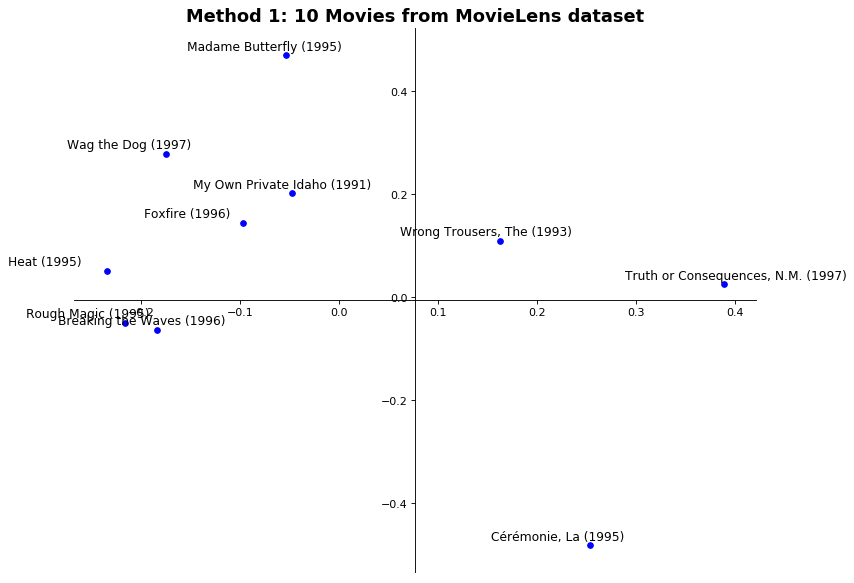

In [158]:
np.random.seed(42)
movies = np.random.choice(list(movie_to_genre.keys()), 10, replace=False)
movie_ids = [movie_to_id[m] for m in movies]

# ====================== TEN CHOSEN MOVIES PLOT ======================
V_ten = np.take(np.transpose(V_tilde), movie_ids, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_ten)):
    x = V_ten[i][0]
    y = V_ten[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.01, movies[i], fontsize=11)
plt.title('Method 1: 10 Movies from MovieLens dataset', fontsize=16, fontweight='bold')
plt.show()

### Plot 10 Most Popular Movies

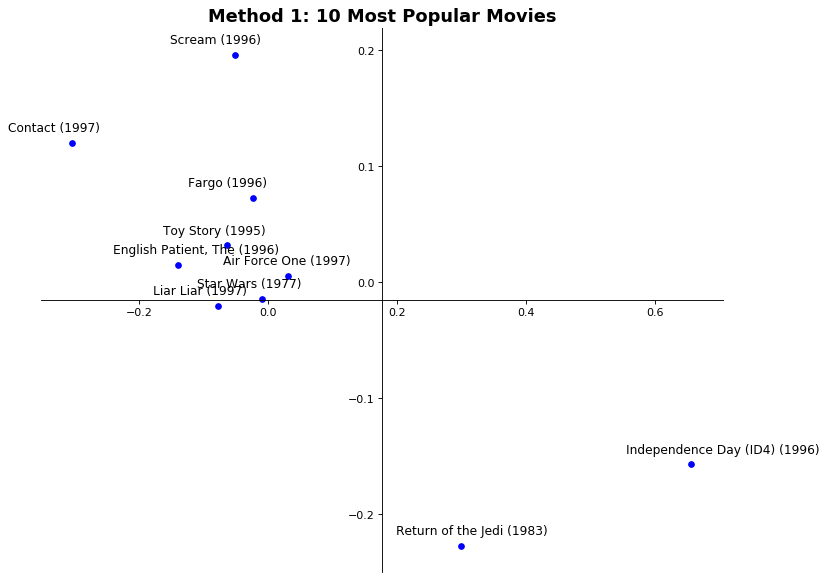

In [159]:
popular_movies = ['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 
                  'Return of the Jedi (1983)', 'Liar Liar (1997)', 
                  'English Patient, The (1996)', 'Scream (1996)', 
                  'Toy Story (1995)', 'Air Force One (1997)', 
                  'Independence Day (ID4) (1996)']
pop_movies_id = [movie_to_id[m] for m in popular_movies]

# ====================== TEN MOST POPULAR MOVIES PLOT ======================
V_pop = np.take(np.transpose(V_tilde), pop_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_pop)):
    x = V_pop[i][0]
    y = V_pop[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.01, popular_movies[i], fontsize=11)
plt.title('Method 1: 10 Most Popular Movies', fontsize=16, fontweight='bold')
plt.show()

### Plot 10 Best Movies

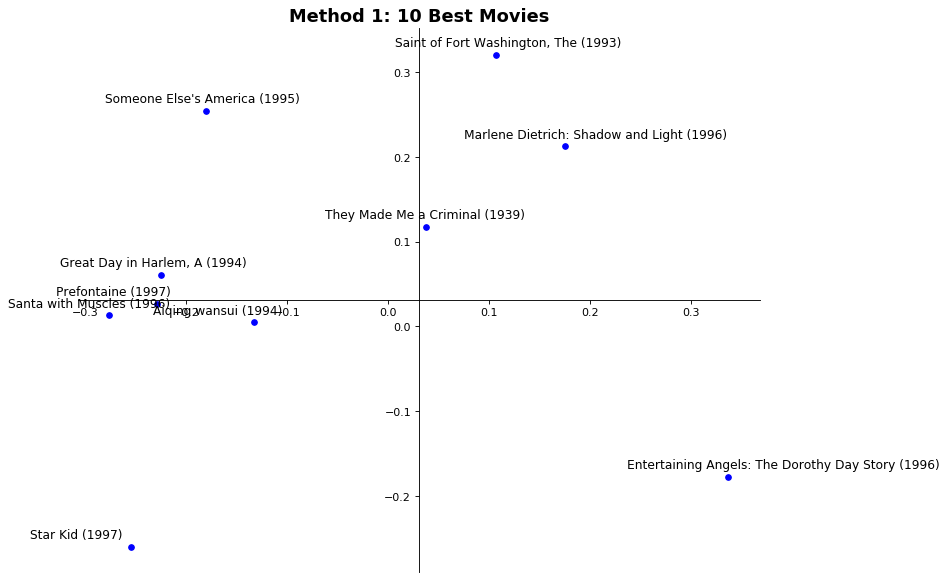

In [156]:
best_movies = ['Prefontaine (1997)', 'Santa with Muscles (1996)', 
               'Great Day in Harlem, A (1994)', 'Aiqing wansui (1994)', 
               'Star Kid (1997)', "Someone Else's America (1995)", 
               'Entertaining Angels: The Dorothy Day Story (1996)', 
               'Saint of Fort Washington, The (1993)', 
               'They Made Me a Criminal (1939)', 
               'Marlene Dietrich: Shadow and Light (1996) ']

best_movies_id = [movie_to_id[m] for m in best_movies]

# ====================== TEN BEST MOVIES PLOT ======================
V_best = np.take(np.transpose(V_tilde), best_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_best)):
    x = V_best[i][0]
    y = V_best[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.01, best_movies[i], fontsize=11)
plt.title('Method 1: 10 Best Movies', fontsize=16, fontweight='bold')
plt.show()

### Plot 10 Movies from 3 Genres

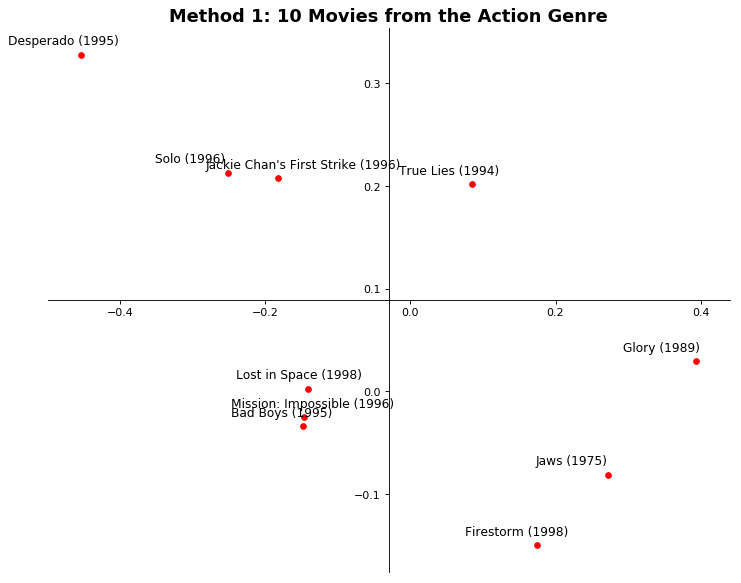

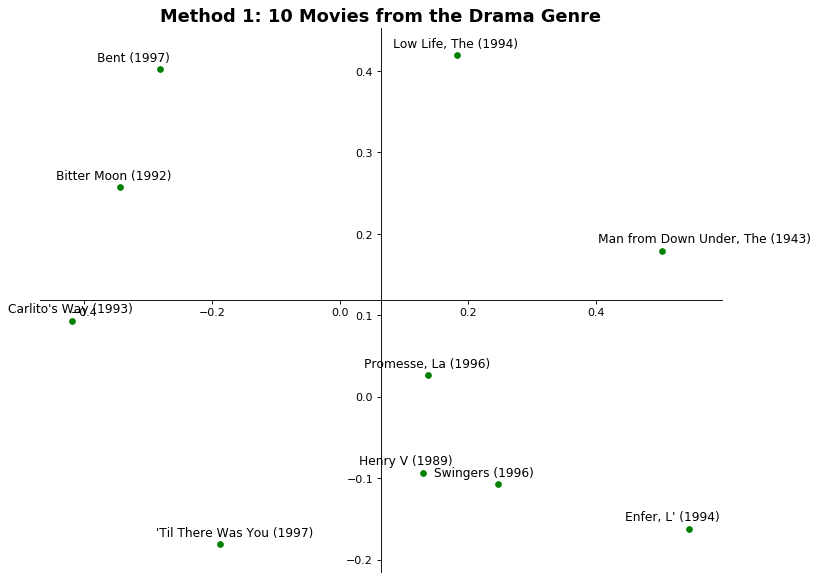

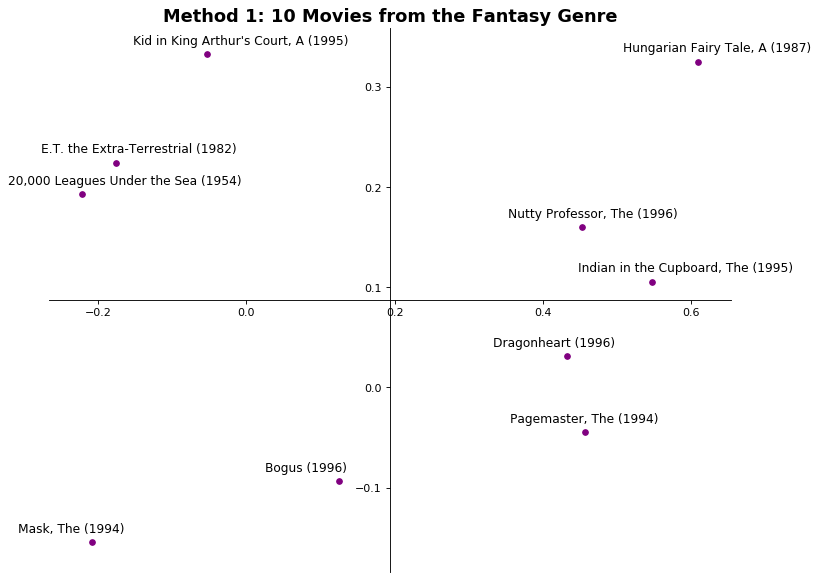

In [155]:
action = []
drama = []
fantasy = []

for key, val in movie_to_genre.items():
    if val[1]:
        action.append(key)
    if val[8]:
        drama.append(key)
    if val[9]:
        fantasy.append(key)
        
np.random.seed(42)       
action = np.random.choice(action, 10, replace=False)
action_id = [movie_to_id[m] for m in action]

np.random.seed(42)
drama = np.random.choice(drama, 10, replace=False)
drama_id = [movie_to_id[m] for m in drama]

np.random.seed(42)
fantasy = np.random.choice(fantasy, 10, replace=False)
fantasy_id = [movie_to_id[m] for m in fantasy]

# ====================== TEN MOVIES FROM EACH OF THE THREE GENRES PLOT ======================

# ACTION GENRE
V_action = np.take(np.transpose(V_tilde), action_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_action)):
    x = V_action[i][0]
    y = V_action[i][1]
    plt.scatter(x, y, marker='.', color='red', s=100)
    plt.text(x - 0.1, y + 0.01, action[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Action Genre', fontsize=16, fontweight='bold')
plt.show()

# DRAMA GENRE
V_drama = np.take(np.transpose(V_tilde), drama_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_drama)):
    x = V_drama[i][0]
    y = V_drama[i][1]
    plt.scatter(x, y, marker='.', color='green', s=100)
    plt.text(x - 0.1, y + 0.01, drama[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Drama Genre', fontsize=16, fontweight='bold')
plt.show()

# FANTASY GENRE
V_fantasy = np.take(np.transpose(V_tilde), fantasy_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_fantasy)):
    x = V_fantasy[i][0]
    y = V_fantasy[i][1]
    plt.scatter(x, y, marker='.', color='purple', s=100)
    plt.text(x - 0.1, y + 0.01, fantasy[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Fantasy Genre', fontsize=16, fontweight='bold')
plt.show()

### Plot Star Wars VS Star Trek Movies

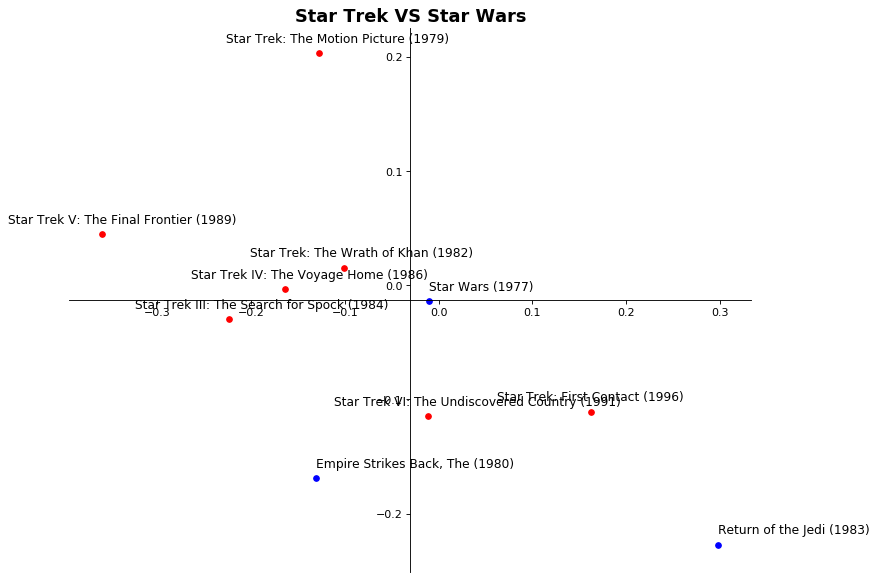

In [149]:
star_trek = ['Star Trek: First Contact (1996)', 'Star Trek VI: The Undiscovered Country (1991)',
        'Star Trek: The Wrath of Khan (1982)', 'Star Trek III: The Search for Spock (1984)',
        'Star Trek IV: The Voyage Home (1986)', 'Star Trek: The Motion Picture (1979)',
        'Star Trek V: The Final Frontier (1989)']

star_wars = ['Star Wars (1977)', 'Return of the Jedi (1983)', 'Empire Strikes Back, The (1980)']

star_trek_id = [movie_to_id[m] for m in star_trek]

star_wars_id = [movie_to_id[m] for m in star_wars]

# ====================== TEN BEST MOVIES PLOT ======================
V_trek = np.take(np.transpose(V_tilde), star_trek_id, axis=0)

V_wars = np.take(np.transpose(V_tilde), star_wars_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_trek)):
    x = V_trek[i][0]
    y = V_trek[i][1]
    plt.scatter(x, y, marker='.', color='red', s=100)
    plt.text(x - 0.1, y + 0.01, star_trek[i], fontsize=11)

for i in range(len(V_wars)):
    x = V_wars[i][0]
    y = V_wars[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x, y + 0.01, star_wars[i], fontsize=11)
    
plt.title('Star Trek VS Star Wars', fontsize=16, fontweight='bold')
plt.show()

In [73]:
from collections import Counter
movie_to_year = dict()

for index, row in movie_info.iterrows():
    if row['title'] not in movie_to_year:
        movie_to_year[row['title']] = row['title'][-5:-1]
        
value = Counter(movie_to_year.values()).most_common(5)
print('Highest occurring years in dataset: ' + str(value))

Highest occurring years in dataset: [('1996', 295), ('1995', 294), ('1994', 237), ('1997', 225), ('1993', 129)]


### Plot 1996 Oscar Nominations
Highest to lowest rating on IMDB:
1. Se7en
2. The Usual Suspects
3. Toy Story
4. Braveheart
5. Casino
6. 12 Monkeys
7. A Little Princess
8. Il Postino 
9. Sense and Sensibility
10. Apollo 13
11. The Bridges of Madison County
12. Leaving Las Vegas
13. Dead Man Walking
14. Richard III
15. Antonia's Line
16. The Star Maker
17. Crimson Tide
18. Mr. Holland's Opus
19. My Family
20. Nixon
21. Shanghai Triad
22. Mighty Aphrodite
23. All Things Fair
24. Rob Roy
25. The American President
26. Pocahontas
27. Babe
28. Don Juan DeMarco
29. Unstrung Heroes
30. O Quatrilho (not in dataset)
31. Restoration
32. Georgia
33. Roommates
34. Sabrina
35. Waterworld
36. Dust of Life
37. Batman Forever

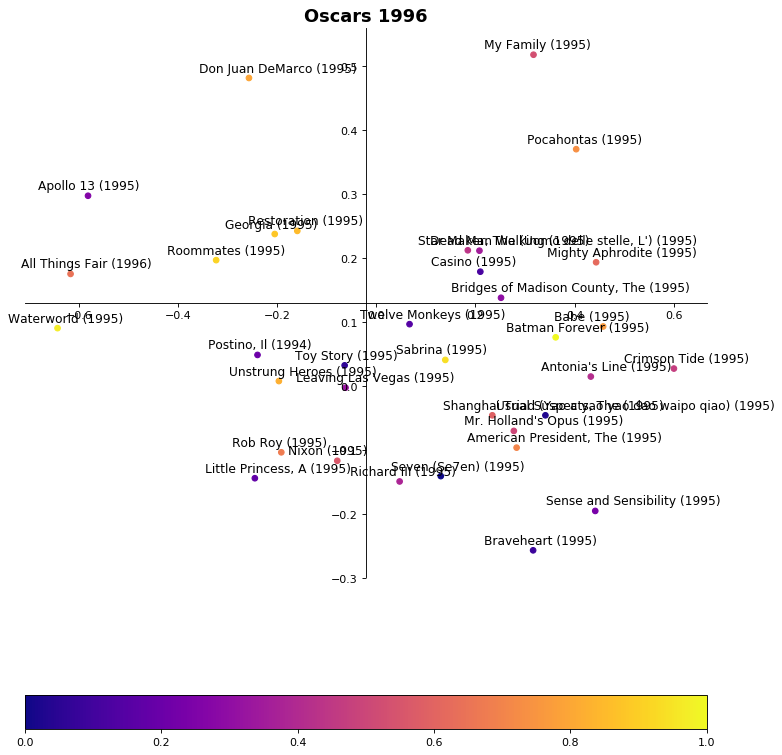

In [161]:
oscars_1996 = ['Seven (Se7en) (1995)', 'Usual Suspects, The (1995)', 
               'Toy Story (1995)', 'Braveheart (1995)', 'Casino (1995)',
               'Twelve Monkeys (1995)', 'Little Princess, A (1995)',
               'Postino, Il (1994)', 'Sense and Sensibility (1995)',
               'Apollo 13 (1995)', 'Bridges of Madison County, The (1995)', 
               'Leaving Las Vegas (1995)', 'Dead Man Walking (1995)', 
               'Richard III (1995)', "Antonia's Line (1995)", 
               "Star Maker, The (Uomo delle stelle, L') (1995)", 
               'Crimson Tide (1995)', "Mr. Holland's Opus (1995)", 
               'My Family (1995)', 'Nixon (1995)', 
               'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
               'Mighty Aphrodite (1995)', 'All Things Fair (1996)', 
               'Rob Roy (1995)', 'American President, The (1995)', 
               'Pocahontas (1995)', 'Babe (1995)','Don Juan DeMarco (1995)', 
               'Unstrung Heroes (1995)', 'Restoration (1995)', 
               'Georgia (1995)', 'Roommates (1995)', 'Sabrina (1995)', 
               'Waterworld (1995)', 'Batman Forever (1995)']

oscars_1996_id = [movie_to_id[m] for m in oscars_1996]

color = np.linspace(0, 1, len(oscars_1996))

# ====================== TEN BEST MOVIES PLOT ======================
V_1996 = np.take(np.transpose(V_tilde), oscars_1996_id, axis=0)

fig = plt.figure(figsize=(11, 13), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_1996)):
    x = V_1996[i][0]
    y = V_1996[i][1]
    plt.text(x - 0.1, y + 0.01, oscars_1996[i], fontsize=11)
    
plt.scatter(V_1996[:,0], V_1996[:,1], marker='.', s=100, c=color, cmap='plasma')
plt.colorbar(orientation="horizontal")

plt.title('Oscars 1996', fontsize=16, fontweight='bold')
plt.show()

### Plot 1995 Oscar Nominations
Highest to lowest rating on IMDB:
1. The Shawshank Redemption
2. Pulp Fiction
3. Forrest Gump
4. The Lion King
5. Three Colors: Red
6. Before the Rain
7. Burnt by the Sun
8. Ed Wood
9. Eat Drink Man Woman
10. Interview with the Vampire: The Vampire Chronicles
11. Legends of Fall
12. Quiz Show
13. The Adventures of Priscilla, Queen of the Desert
14. Nobody's Fool
15. Queen Margot
16. Bullets Over Broadway
17. Strawberry and Chocolate
18. Little Women
19. Heavenly Creatures
20. True Lies
21. Speed
22. The Madness of King George
23. Four Wedding and a Funeral
24. Maverick
25. The Mask
26. Clear and Present Danger
27. Farinelli
28. Wyatt Earp
29. The Client
30. The Paper
31. Nell
32. Mary Shelley's Frankenstein
33. Blue Sky
34. Tom & Viv
35. Junior

In [ ]:
oscars_1995 = ['Shawshank Redemption, The (1994)', ]

oscars_1995_id = [movie_to_id[m] for m in oscars_1995]

color = np.linspace(0, 1, len(oscars_1995))

# ====================== TEN BEST MOVIES PLOT ======================
V_1995 = np.take(np.transpose(V_tilde), oscars_1995_id, axis=0)

fig = plt.figure(figsize=(11, 13), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_1995)):
    x = V_1995[i][0]
    y = V_1995[i][1]
    plt.text(x - 0.1, y + 0.01, oscars_1995[i], fontsize=11)
    
plt.scatter(V_1995[:,0], V_1995[:,1], marker='.', s=100, c=color, cmap='plasma')
plt.colorbar(orientation="horizontal")

plt.title('Oscars 1995', fontsize=16, fontweight='bold')
plt.show()